# From https://github.com/justinsalamon/skm

In [ ]:
%matplotlib inline
import skm
import skm.display
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Generate example data to cluster

In [ ]:
# Generate some example data
npoints = 200
rA = 5 + np.random.normal(size=npoints, scale=1)
rB = 7 + np.random.normal(size=npoints, scale=2)
rC = 5 + np.random.normal(size=npoints, scale=1)
phiA = np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0)
phiB = -np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/32.0)
phiC = 5/4.0  * np.pi + np.random.normal(size=npoints, scale=np.pi/8.0)

pointsA = np.array([rA * np.cos(phiA), rA * np.sin(phiA)])
pointsB = np.array([rB * np.cos(phiB), rA * np.sin(phiB)])
pointsC = np.array([rC * np.cos(phiC), rA * np.sin(phiC)])

In [ ]:
# Note skm expects data in the format [dimensions, samples]
# For example: [mfcc_coefficients, frames]
print(pointsA.shape)
print(pointsB.shape)
print(pointsC.shape)

(2, 200)
(2, 200)
(2, 200)


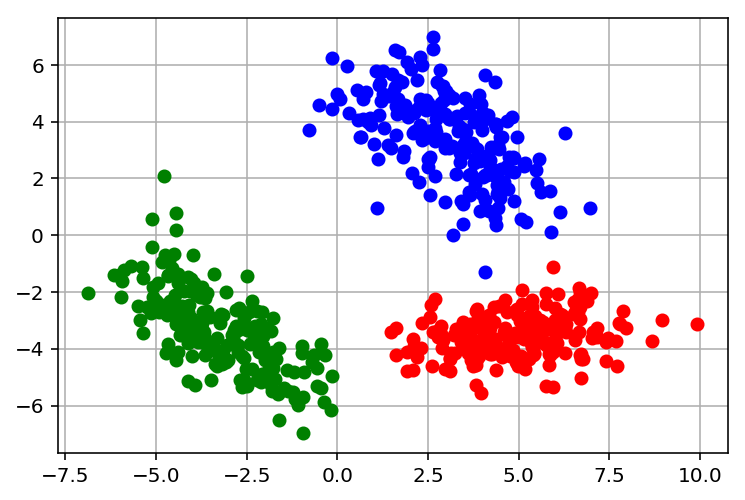

In [ ]:
# Plot the data
plt.plot(pointsA[0], pointsA[1], 'bo')
plt.plot(pointsB[0], pointsB[1], 'ro')
plt.plot(pointsC[0], pointsC[1], 'go')
plt.grid()
plt.show()

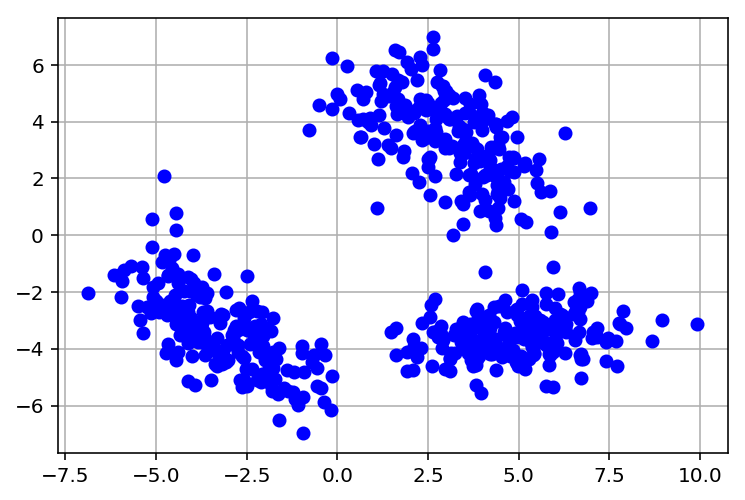

In [ ]:
# Combine into single dataset and shuffle
data = np.concatenate((pointsA.T, pointsB.T, pointsC.T))
np.random.shuffle(data)
data = data.T
plt.plot(data[0,:], data[1,:], 'bo')
plt.grid()
plt.show()

## Cluster using SKM

In [ ]:
# Create SKM object
s = skm.SKM(k=10, assignment_change_eps=0.01, normalize=False,
            standardize=False, variance_explained=0.99, visualize=False)

In [ ]:
# Fit
s.fit(data)

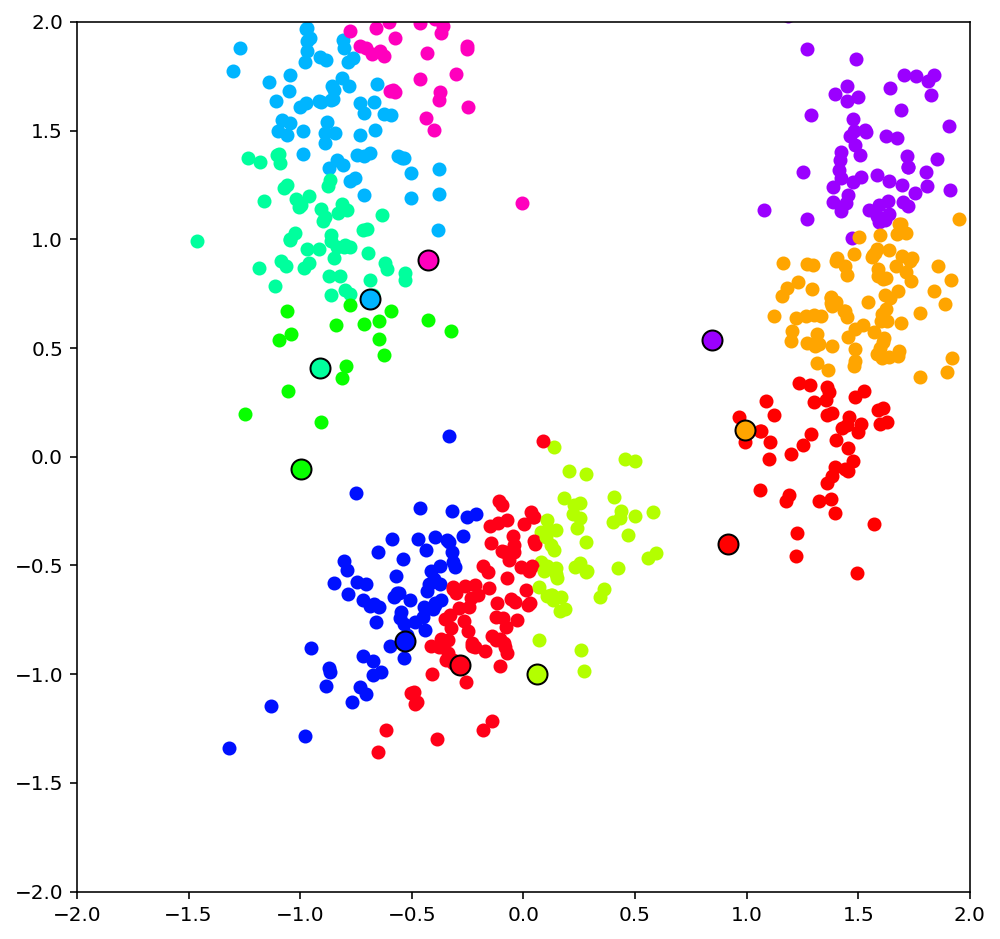

In [ ]:
# Visualize cluster assignments (data must be tranformed using the SKM's learned PCA)
skm.display.visualize_clusters(s, s.pca.transform(data.T).T)

## Get the learned dictionary

In [ ]:
s.D

array([[ 0.917,  0.992,  0.063, -0.998, -0.912, -0.686, -0.531,  0.844, -0.426, -0.283],
       [-0.399,  0.125, -0.998, -0.058,  0.409,  0.727, -0.848,  0.537,  0.905, -0.959]])

In [ ]:
s.D.shape

(2, 10)

## Get the learned PCA transform

In [ ]:
s.pca

PCA(copy=False, iterated_power='auto', n_components=0.99, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True)

In [ ]:
# transform the input data
data_pca = s.pca.transform(data.T).T

In [ ]:
data_pca.shape

(2, 600)

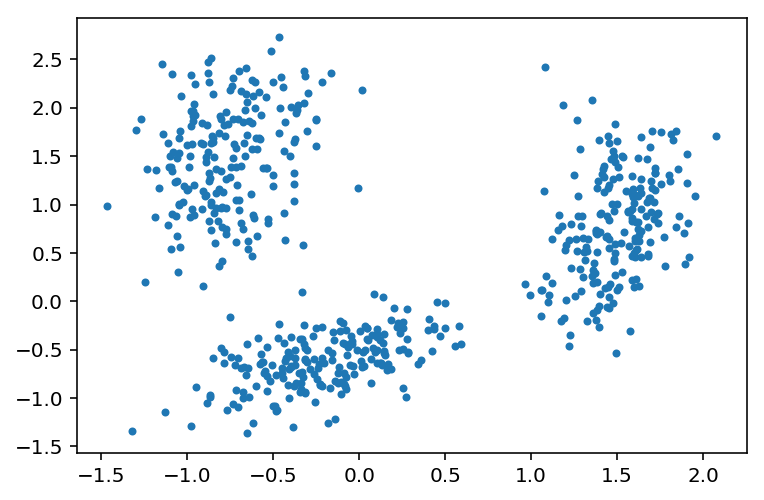

In [ ]:
plt.plot(data_pca[0, :], data_pca[1, :], '.')

## Transform new incoming data

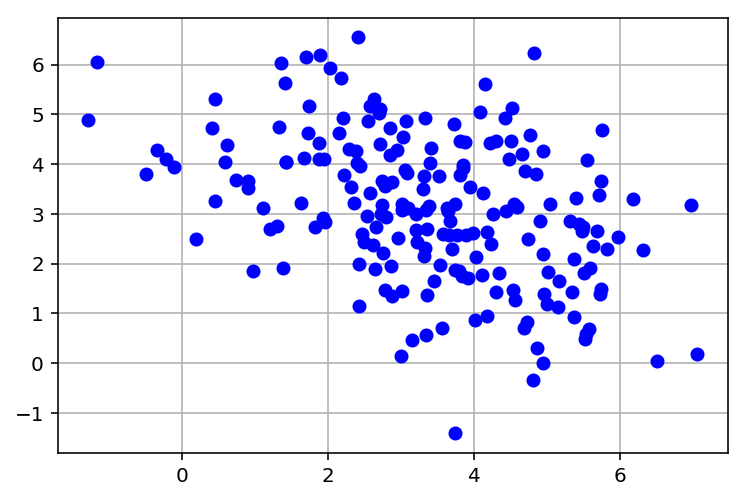

In [ ]:
# let's create some new data
rD = 5 + np.random.normal(size=200, scale=1)
phiD = np.pi/4.0 + np.random.normal(size=npoints, scale=np.pi/8.0)
pointsD = np.array([rD * np.cos(phiD), rD * np.sin(phiD)])

newdata = pointsD
plt.plot(newdata[0], newdata[1], 'bo')
plt.grid()
plt.show()

In [ ]:
newdata.shape

(2, 200)

In [ ]:
# Next we call SKM.fit(), which applies the learned PCA to the data and then projects it against the learned
# cluster dictionary D:
newdata_proj = s.transform(newdata)

In [ ]:
# Notice how now the dimensionality is 10 (centroids) by 200 (samples)
newdata_proj.shape

(10, 200)

In [ ]:
# Finally, we may want to summarize the projection over the time dimension
# Here we assume dim 0 represents features and dim 1 represents time

# Let's define a pooling function
def pool_features(X, pooling=['mean', 'std', 'min', 'max']):
    '''
    Given samples X (where each column vector is a feature vector for a sample),
    summarize each feature in X across all samples using a pooling function
    (e.g. max, min, mean, std, etc.)
    X = [n_dimensions, n_samples]
    '''
    pooled_features = []

    if 'mean' in pooling:
        pooled_features.extend(np.mean(X, axis=1))

    if 'std' in pooling:
        pooled_features.extend(np.std(X, axis=1))

    if 'min' in pooling:
        pooled_features.extend(np.min(X, axis=1))

    if 'max' in pooling:
        pooled_features.extend(np.max(X, axis=1))

    if 'median' in pooling:
        pooled_features.extend(np.median(X, axis=1))

    if 'skewness' in pooling:
        pooled_features.extend(scipy.stats.skew(X, axis=1))

    if 'kurtosis' in pooling:
        pooled_features.extend(scipy.stats.kurtosis(X, axis=1))

    if 'dmean' in pooling:
        pooled_features.extend(np.mean(np.diff(X, axis=1), axis=1))

    if 'dstd' in pooling:
        pooled_features.extend(np.std(np.diff(X, axis=1), axis=1))

    if 'dmean2' in pooling:
        pooled_features.extend(np.mean(np.diff(np.diff(X, axis=1), axis=1), axis=1))

    if 'dstd2' in pooling:
        pooled_features.extend(np.std(np.diff(np.diff(X, axis=1), axis=1), axis=1))

    return np.asarray(pooled_features)

In [ ]:
newdata_pooled = pool_features(newdata_proj, pooling=['mean', 'max'])

In [ ]:
# After pooling, we get a feature vector of size k x p where:
# k = number of clusters in D
# p = number of pooling functions
# In this example we use 2 pooling functions (mean and max), so we get a vector of size 20:
newdata_pooled.shape

(20, )

In [ ]:
# Finally we can use this feature vector to train/test classification models.

## Saving and loading SKM objects

In [ ]:
# For later use, we may want to save/load trainde SKM objects.
# skm saves SKM as 2 files, a json file and an npz file:
jsonfile = '/tmp/skm.json'
npzfile = '/tmp/skm.npz'

# The correct function to use is save_persistent
s.save_persistent(jsonfile, npzfile)

In [ ]:
# Now let's load in the skm object
s_loaded = skm.SKM.load_persistent(jsonfile, npzfile)

In [ ]:
(s_loaded.D == s.D).all()

True

In [ ]:
(s_loaded.pca.components_ == s.pca.components_).all()

True